In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tiingo import TiingoClient
pd.core.common.is_list_like = pd.api.types.is_list_like
import ffn
import statsmodels.api as sm
import scipy.stats as st
import bt
import cvxopt as opt
from cvxopt import blas, solvers
import seaborn as sns
from pypfopt import risk_models

In [2]:
config = {}
# To reuse the same HTTP Session across API calls (and have better performance), include a session key.
config['session'] = True
config['api_key'] = "9606b7b7c092fa68b5726d3feee8d44f40354fe3"
# Initialize
client = TiingoClient(config)

# 2 - Portfolio Analysis: A Primer

In [ ]:
# 2.1.2
start_date='2000-01-01'
end_date='2018-12-01'
tickers = ['SPY','IEF']


start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
#     prices[ticker] = get_historical_data(ticker, start=start_date, end=end_date, output_format='pandas').loc[:,'close']
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
print(prices.head())
rets = prices.pct_change()
rets = rets.dropna()
print(rets.head())
perf = prices.calc_stats()

In [ ]:
# 2.1.3
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rets.SPY* 100)
ax.set(title='Daily S&P 500 Returns', xlabel='Date', ylabel='Return')

In [ ]:
# 2.1.4
# 2.1.4
sp500_index = np.cumprod(1 + rets.SPY)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sp500_index)
ax.set(title='S&P 500 Index', xlabel='Date', ylabel='Price')

In [ ]:
# 2.1.5
sp500_index = 100*np.cumprod((1+rets.SPY))

In [ ]:
# 2.1.6 
sp500_ret = sp500_index.pct_change().dropna()

In [ ]:
# 2.1.7
data_test = pd.concat([sp500_ret, rets.SPY],axis=1)

In [ ]:
# 2.1.8
sp500_12mo_ret = prices.SPY.pct_change(252).dropna()

In [ ]:
# 2.2.1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(prices.pct_change(21))
ax.set(title='S&P 500 vs 10-Year Treasury', xlabel='Date', ylabel='% Return')


In [ ]:
# 2.3.1
vol = rets.std()
print(vol)
# 2.3.2
vol_annualized = vol * np.sqrt(252)
print(vol_annualized)

# 2.3.3
vol_roll = rets.rolling(window=252).std().dropna()
print(vol_roll.head())
 
# 2.3.4
corr_matrix = rets.corr()
corr_roll = rets.SPY.rolling(window=252).corr(other=rets.IEF).dropna()
print(corr_matrix)
print(corr_roll.head())

In [ ]:
# 2.4.1
round(rets.SPY.std(), 5)
 
# 2.4.2
# round(returns.geltner(rets.SPY).std(),5)
# TODO

# # 2.4.3
round(rets.SPY.std()*np.sqrt(252), 5)
 
# # 2.4.4
def SharpeRatio(returns, rf=0.01/252, N=252):
    """Calculate annualized sharpe ratio:
    :dataframe returns: a dataframe, asset returns
    :param rf: a float, the risk free rate, default=1%
    :param N: an int, the number of trading periods, default=252
    
    RETURNS:
    :Sharpe Ratio: float"""
    return np.sqrt(N) * (returns.mean() - rf) / returns.std()
round(SharpeRatio(rets.SPY), 3)

In [ ]:
# 2.5.1
round(perf['SPY'].stats['yearly_sortino'], 3)

In [ ]:
# 2.6.1 
# CAPM.beta(Ra=managers$EDHEC, Rb=managers$SP500)
 
# 2.6.2
model =sm.OLS(rets.IEF, rets.SPY)
results = model.fit()
beta=float(results.params)
print(round(beta,3))

In [ ]:
# 2.7.1
scipy.stats.norm.ppf(0.05, loc=0.07, scale=0.1)
 
# 2.7.2
scipy.stats.norm.cdf(-0.09448536,loc=0.07, scale=0.1)
 
# 2.7.3
scipy.stats.norm.ppf([0.05,0.01,0.001], loc=0.07, scale=0.1) 
 
# 2.7.4
np.random.seed(87655678)
ret_sim = np.random.normal(loc=0.07, scale=0.1, size=10000)
ret_sim_var = np.quantile(ret_sim, [0.05, 0.01, 0.001])

# 2.7.5
np.quantile(rets.SPY.pct_change(252).dropna(), 0.05)
 
# # 2.7.6
sp500_sort = rets.SPY.sort_values()
sp500_sort_var95 = np.quantile(sp500_sort,0.05)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,len(sp500_sort)),sp500_sort)
ax.axhline(y=-0.05,color='red')
ax.set(title='Sorted S&P 500 Returns', xlabel='Date', ylabel='% Return')

In [ ]:
# 2.8.1
scipy.stats.norm.cdf(0,loc=rets.SPY.mean(), scale=rets.SPY.std())
 
# 2.8.2
rets.SPY.mean()
 
# 2.8.3
1-scipy.stats.norm.cdf(0, loc=rets.SPY.mean(), scale=rets.SPY.std())
 

In [ ]:
# 2.9.1
drawdown_series = ffn.to_drawdown_series(prices.SPY)
drawdowns = ffn.drawdown_details(drawdown_series)
drawdowns.sort_values(by='Length', ascending=False)[0:3]

# 2.9.2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(drawdown_series * 100)
ax.set(title='Sorted S&P 500 Drawdowns', xlabel='Date', ylabel='Drawdown %')
 

# 3 - Rebalancing and Backtesting

In [ ]:
# 3.1.1
weights = pd.Series([0.6,0.4],index = prices.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
s = bt.Strategy('Rebalance', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])

test = bt.Backtest(s, prices)
s2 = bt.Strategy('No Rebalance', [bt.algos.RunOnce(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])

test2 = bt.Backtest(s2, prices)
res= bt.run(test, test2)
res.plot()


In [ ]:
# 3.1.2
res.display()

In [ ]:
# 3.2.1
sma  = prices.rolling(window=252,center=False).mean().shift(1) # create trend signal
trend = sma.copy()
trend[prices > sma] = True
trend[prices <= sma] = False
trend[sma.isnull()] = False

# 3.2.2-3.27
s3 = bt.Strategy('Moving Average', [bt.algos.RunMonthly(),
                       bt.algos.SelectWhere(trend),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

test3 = bt.Backtest(s3, prices)
res= bt.run(test, test2, test3)
res.plot()
res.display()


# 4 - Estimating "Optimal" Portfolios

In [ ]:
# 4.1.1
start_date='2000-01-01'
end_date='2018-06-01'
tickers = ['SPY','IEF','EFA','DBC','TIP']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()

In [ ]:
# 4.1.2
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

In [ ]:
# 4.1.3
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

In [ ]:
# 4.1.4
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0.1, 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

# 5 Factor Analysis

In [ ]:
# 5.1.1
import pandas_datareader as pdr
from pandas_datareader.famafrench import get_available_datasets
french = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench',start = "2000-01-01")[0]
french.head()

In [ ]:
# 5.1.2
start_date='2000-01-01'
end_date='2018-06-01'
tickers = ['SPY','BIL']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna() * 100
sp500_premium = returns.SPY - returns.BIL
sp500_premium = pd.DataFrame(data=sp500_premium)
sp500_premium.columns = ['sp500_premium']

In [ ]:
# 5.1.3
french_factors_sp500 = sp500_premium.join(french, how='left')
# french_factors_sp500.sp500 = french_factors_sp500.sp500 - french_factors_sp500.RF

In [ ]:
french_factors_sp500.head()

In [ ]:
# 5.1.4
import statsmodels.api as sm
results = sm.OLS(french_factors_sp500.sp500_premium,french_factors_sp500.iloc[:,1:-1]).fit()

In [ ]:
# 5.1.5
print(results.summary())

In [ ]:
# 5.1.6
estimates = results.get_prediction(french_factors_sp500.iloc[:,1:-1]).summary_frame()
estimates= estimates.loc[:,'mean']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(french_factors_sp500.sp500_premium, estimates, marker='o', facecolors='none', edgecolors='b')
ax.set(title='Fama-French 3-factor Model for S&P 500', xlabel='historical premia', ylabel='estimated premia')

In [ ]:
# 5.2.1 
managers = pd.read_csv("managers.csv", index_col=0)
returns = managers.dropna().iloc[:,0:6]

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn import preprocessing

fa = FactorAnalysis(n_components=1, tol=1e-6, max_iter=10000)
returns_normal = -1*preprocessing.scale(returns)
fa.fit(returns_normal)
loadings = pd.DataFrame(fa.components_[0], index=managers.columns[0:6],columns=['Loadings'])
print(loadings)
print("Sum of Squared Loadings: ", np.sum(fa.components_[0] **2)) # Note this is for a single factor. Will need to be more Numpy-ish if using multiple factors
print("Explained Variance: ", np.sum(fa.components_[0] **2)/(np.sum(fa.components_[0]**2) + np.sum(fa.noise_variance_)))

In [ ]:
# 5.2.2
from sklearn.decomposition import PCA
pca = decomposition.PCA(n_components=6)
pca.fit(returns)
eigenvalues = pca.explained_variance_
pca_variances = pd.DataFrame(data=eigenvalues, columns=['Variance'], index=["PC" +str(i) for i in range(1,7)]).sort_values(by='Variance',ascending=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=pca_variances.index, height=pca_variances.Variance)
ax.set(title='PCA Portfolio Variance', xlabel='Principal Component Portfolios', ylabel='Variance')

In [ ]:
# 5.2.3
standard_deviation = np.sqrt(pca.explained_variance_)
prop_variation = pca.explained_variance_ratio_
cumulative_proporiton = np.cumsum(pca.explained_variance_ratio_)
pca_summary = pd.DataFrame(data={'Standard Deviation':standard_deviation, 'Proportion of Variance':prop_variation, 'Cumulative Proportion':cumulative_proporiton},
                           index=["PC" +str(i) for i in range(1,7)])
pca_summary.transpose()

In [ ]:
pca.components_[0]

In [ ]:
sum(pca.components_[0]/sum(pca.components_[0]))

In [ ]:
# 5.2.4
eigenfolios = np.empty(shape=6)
for i in range(len(pca.components_)):
    denom = sum(pca.components_[i])
    eigenfolio = pca.components_[i]/denom
    eigenfolios = np.vstack((eigenfolios, eigenfolio))
eigenfolios=eigenfolios[1:]
eigenfolios = pd.DataFrame(data=eigenfolios, index=["PC" +str(i) for i in range(1,7)], columns=managers.columns[0:6])
eigenfolios.transpose()

In [ ]:
# 5.2.5
eigenfolios.transpose().sum()

In [ ]:
# 5.2.6
start_date='2000-01-01'
end_date='2018-06-01'
tickers = ['SPY','AGG','EFA','EEM','USO']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()

In [ ]:
# 5.2.7
returns = prices.pct_change().dropna()
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(returns)
pca.components_
pd.DataFrame(data=pca.components_, index=["PC" +str(i) for i in range(1,6)], columns=tickers).transpose()

In [ ]:
# 5.2.8
eigenfolios = np.empty(shape=5)
for i in range(len(pca.components_)):
    denom = sum(pca.components_[i])
    eigenfolio = pca.components_[i]/denom
    eigenfolios = np.vstack((eigenfolios, eigenfolio))
eigenfolios=eigenfolios[1:]
eigenfolios = pd.DataFrame(data=eigenfolios, index=["PC" +str(i) for i in range(1,6)], columns=tickers)
eigenfolios.transpose().iloc[:,0]

# 6 - Monte Carlo Simulations

In [ ]:
#############
# Chapter 6 #
#############
 
# FIX SEEDS THEY NEED TO GO INSIDE SAMPLE FUNCTION 

# 6.1.1
import random

managers = pd.read_csv("managers.csv", index_col=0)
ret_sp500 = managers['SP500 TR']
random.seed(994)
ret_sp500_sim_1 = ret_sp500.sample(n=len(ret_sp500),replace=True)

In [ ]:
# 6.1.2
import matplotlib.dates as mdates
ret_sp500_sim_1.index= ret_sp500.index
ret_all = pd.concat([ret_sp500, ret_sp500_sim_1], axis=1)
ret_all.columns = ['Actual', 'Simulated']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ret_all)
ax.set(title='Monthly Returns')
ax.legend(ret_all.columns)

# FIX DATETIME AXIS

In [ ]:
# 6.1.3
random.seed(645)
ret_sp500_sim_2 = ret_sp500.sample(n=1000, replace=True)

In [ ]:
# 6.1.4
managers = pd.read_csv("managers.csv", index_col=0)
ret_a = managers.iloc[:,7:10]
random.seed(44)
ret_a_sim = ret_a.sample(n=len(ret_a),replace=True)

In [ ]:
# 6.1.5
def fun_a(returns, sim=False, wgt_a=[0.6,0.3,0.1]):
    weights = pd.Series(wgt_a,index = returns.columns)
    weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
    s = bt.Strategy('Rebalance', [bt.algos.RunYearly(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])
    if sim==True:
        ret_sim = returns.sample(n=len(returns), replace=True)
        ret_sim.index = returns.index
        prices = np.cumprod(np.exp(ret_sim))
    else:
        prices = np.cumprod(np.exp(returns))
    test = bt.Backtest(s, prices,progress_bar=False)
    res= bt.run(test)
    return res.prices

In [ ]:
# 6.1.6
start_date='2000-01-01'
end_date='2018-06-01'
tickers = ['SPY','BIL','IEF']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change().dropna()
port_sim_test = fun_a(returns, sim=False)
port_sim_test.head()

In [ ]:
# 6.1.7
random.seed(48)
port_sim_a = pd.concat([fun_a(returns, sim=True) for _ in range(10)], axis=1)

In [ ]:
# 6.1.8
weights = pd.Series([0.6,0.3,0.1],index = returns.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
s = bt.Strategy('Rebalance', [bt.algos.RunYearly(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])
prices = np.cumprod(np.exp(returns))
test = bt.Backtest(s, prices,progress_bar=False)
res = bt.run(test)
port_actual = res.prices

In [ ]:
# 6.1.9
wi_all = pd.concat([port_actual,port_sim_a],axis=1)
sims=['sim'+str(i) for i in range(1,11)]
sims.append('actual')
sims.sort()
wi_all.columns = [sims]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wi_all.actual)
ax.plot(wi_all.iloc[:,1:], color='k', linestyle='--', linewidth=0.5)
ax.set(title='Wealth Indexes')

In [ ]:
# 6.2.1
import scipy.stats as st
random.seed(401)
ret = st.norm.rvs(loc=0.05, scale=0.10, size=100)

In [ ]:
# 6.2.2
prices_a = np.cumprod(1+ret)

In [ ]:
# 6.2.3
managers = pd.read_csv("managers.csv", index_col=0)
mean_ret = managers.iloc[:,7].mean()
print("Mean Return ", mean_ret)
sd_1 = managers.iloc[:,7].std()
print("Standard Deviation" , sd_1)

In [ ]:
# 6.2.4
random.seed(49)
sp500_sim = st.norm.rvs(loc=mean_ret, scale=sd_1, size=100)
sp500_sim[0:5]

In [ ]:
# 6.2.5
sp500_sim_a = pd.Series(data=st.norm.rvs(loc=mean_ret, scale=sd_1, size=len(managers.iloc[:,7])),index=managers.iloc[:,7].index, random_state=49)
sp500_sim_a.head()

In [ ]:
# 6.2.6
assets_sim = st.norm.rvs(loc=managers.iloc[:,7:10].mean(), scale=managers.iloc[:,7:10].std(), size=(len(managers.iloc[:,7:10]), len(managers.iloc[:,7:10].columns)),random_state=666)
assets_sim = pd.DataFrame(data=assets_sim, columns=managers.iloc[:,7:10].columns, index=managers.iloc[:,7:10].index)
assets_sim.head()

In [ ]:
# 6.2.7
print(managers.iloc[:,7:10].mean())
print(assets_sim.mean())

In [ ]:
# 6.2.8
print(managers.iloc[:,7:10].std())
print(assets_sim.std())

In [ ]:
# 6.3.1
tdist_ret = st.t(df=13).rvs(100000) * 0.01

In [ ]:
# 6.3.2
managers = pd.read_csv("managers.csv", index_col=0)
spy_ret = managers.iloc[:,7]
spy_t_model = st.t.fit(spy_ret) 
spy_t_model

In [ ]:
# 6.3.3
norm_ret = st.norm.rvs(size=100000, loc=0.05/252, scale=0.15/np.sqrt(252), random_state=77)

In [ ]:
# 6.3.4
t_kurt = st.kurtosis(tdist_ret)
norm_kurt = st.kurtosis(norm_ret)
print(t_kurt)
print(norm_kurt)

In [ ]:
# 6.3.5
norm_ret = st.norm.rvs(size=100, loc=0.05/252, scale=0.15/np.sqrt(252), random_state=77)
prices_a = np.cumprod(1+norm_ret)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(prices_a)
ax.set(title='Wealth Indexes')

In [ ]:
# 6.3.6
{x:data.loc[:,x] for x in managers.iloc[:,7:10].columns}
fit = {ticker: st.t.fit(managers.loc[:,ticker]) for ticker in managers.iloc[:,7:10].columns}
mu = [item[1][1] for item in fit.items()]
sigma = [item[1][2] for item in fit.items()]
nu = [item[1][0] for item in fit.items()]
n = len(managers.iloc[:,7:10])
sim_dat = st.t.rvs(df=nu, loc=mu, scale=sigma, size=(n, 3), random_state=198)
sim_dat_ts = pd.DataFrame(data=sim_dat, index=managers.index, columns=managers.columns[7:10])

In [ ]:
# 6.4.1
ret_1 = managers.iloc[:,[0,2,3,7]]
ret_1.columns = ['HF-A','HF-B','HF-C','SP500']
coefficients_1 = sm.OLS(ret_1.SP500,ret_1.iloc[:,:-1]).fit()
coefficients_1.params

In [ ]:
# 6.4.2
from sklearn.linear_model import LinearRegression
def coef(A):
    reg = LinearRegression(fit_intercept=True)
    X = A[:,:-1]
    y = A[:,-1]
    reg.fit(X, y)
    return {"coef": reg.coef_, "intercept": reg.intercept_}

In [ ]:
# 6.4.3
results = bootstrap(a=ret_1, f=coef, b=10000, family='t')
param_frame = pd.DataFrame([pd.Series(x) for x in results])

In [ ]:
# 6.4.4
HFB_coef = param_frame["coef"].map(lambda x: x[1])
print(np.quantile(HFB_coef, q=[0.025, 0.975]))

# 6.4.5
# import seaborn as sns
sns.distplot(HFB_coef, hist=True)

# 7 - Modeling Tail Risk

In [ ]:
#############
# Chapter 7 #
#############
 
# 7.1.1
alpha = np.array([0.05, 0.01])
conf_l= 1-alpha
VaR_1 = st.norm.ppf(q=alpha, loc=0.07, scale=0.15)
VaR_1

In [ ]:
# 7.1.2
VaR_1_alt = 0.07 + 0.15 * st.norm.ppf(q=alpha)
VaR_1_alt

In [ ]:
# 7.1.3
prob_1 = st.norm.cdf(-0.176728, loc=0.07, scale=0.15)
prob_1

In [ ]:
# 7.1.4
es_1 = 0.07 + 0.15 * st.norm.pdf(st.norm.ppf(q=alpha))/alpha
es_1

In [ ]:
# 7.1.5
alpha = np.linspace(0.05, 0.001, num=1000)
conf_1 = 1 -alpha
VaR_a = 0.07 + 0.15 * st.norm.ppf(q=alpha)
ES_a = 0.07 + 0.15 * (st.norm.pdf(st.norm.ppf(q=alpha))/alpha) * -1
columns = ['VaR','ES']
data = [VaR_a, ES_a]
VaR_ES_a = pd.DataFrame(dict(zip(columns, data)))
VaR_ES_a.index = conf_1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(VaR_ES_a)
ax.set(ylabel='loss', title='Value at Risk & Expected Shortfall')
ax.legend(VaR_ES_a.columns, loc='lower left')

In [ ]:
# 7.1.6
managers = pd.read_csv("managers.csv", index_col=0)
sp500_ret = managers.iloc[:,7]
fit_norm = st.norm.fit(sp500_ret)
alpha = 0.05
mu = fit_norm[0]
sigma = fit_norm[1]
VaR_norm = mu + sigma * st.norm.ppf(q=alpha)
VaR_norm

In [ ]:
# 7.1.7
managers = pd.read_csv("managers.csv", index_col=0)
sp500_ret = managers.iloc[:,7]
fit_t = st.t.fit(sp500_ret)
alpha = 0.05
nu = fit_t[0]
mu = fit_t[1]
sigma = fit_t[2]
VaR_t = sigma * st.t(df=nu).ppf(q=alpha)
VaR_t

In [ ]:
# 7.1.8
managers = pd.read_csv("managers.csv", index_col=0)
sp500_ret = managers.iloc[:,7]
g=sns.distplot(sp500_ret, bins=50, kde=False)
plt.title("Distribution of S&P 500 Returns")
plt.axvline(x=VaR_norm, lw=2)
plt.axvline(x=VaR_t,linestyle='--', lw=1)
plt.legend(["VaR Normal Distribution", "VaR T Distribution"])

In [ ]:
# 7.1.8
managers = pd.read_csv("managers.csv", index_col=0)
sp500_ret = managers.iloc[:,7]
def ES(data):
    fit_t = st.t.fit(data)
    alpha = 0.05
    nu = fit_t[0]
    mu = fit_t[1]
    sigma = fit_t[2]
    VaR_t = sigma * st.t(df=nu).ppf(q=alpha)
    return VaR_t

es_ttm = sp500_ret.rolling(window=12).apply(ES)
sns.barplot(x=sp500_ret.index, y=sp500_ret, color='k')
sns.lineplot(x=es_ttm.index, y=es_ttm)

In [ ]:
# FIX DATE LABELS ON AXIS
import matplotlib.dates as mdates
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=sp500_ret.index, height=sp500_ret, color='k')
ax.plot_date(es_ttm.index, es_ttm, fmt='-')
ax.set(ylabel='Value',title='S&P 500 Return & ES')
ax.minorticks_off()
years=mdates.YearLocator()
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 

In [ ]:
# 7.2.1
start_date='1991-12-31'
end_date='2018-12-01'
tickers = ['VFINX','VFITX']


start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
#     prices[ticker] = get_historical_data(ticker, start=start_date, end=end_date, output_format='pandas').loc[:,'close']
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()


weights = pd.Series([0.6,0.4],index = returns.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
port_60_40 = bt.Strategy('Rebalance', [bt.algos.RunYearly(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])
test = bt.Backtest(port_60_40, prices,progress_bar=True)
res = bt.run(test)
port_ret = res.prices.pct_change().dropna()

In [ ]:
fig, ax = plt.subplots()
sns.distplot(port_ret, bins=100,kde=False, fit=st.norm, ax=ax)
ax.legend(labels=["normal","empirical"])
ax.set(ylabel="Denisty",title="Distribution of 60/40 Returns")

In [ ]:
# 7.2.2
# FIX ADD LEGEND (NOT RENDERING FOR SOME REASON)
fit = st.norm.fit(port_ret)
norm_data = st.norm.rvs(size=10000, loc=fit[0], scale=fit[1])

fig, ax = plt.subplots()
g=sns.distplot(port_ret,hist=False,kde_kws=dict(cumulative=True), ax=ax)
h=sns.distplot(norm_data,hist=False,kde_kws=dict(cumulative=True), ax=ax)
ax.set(ylabel='F(x)',title='CDF')

In [ ]:
# 7.2.3
fit = st.norm.fit(port_ret)
norm_data = st.norm.rvs(size=10000, loc=fit[0], scale=fit[1])

fig, ax = plt.subplots()
g=sns.distplot(port_ret,hist=False,kde_kws=dict(cumulative=True), ax=ax)
h=sns.distplot(norm_data,hist=False,kde_kws=dict(cumulative=True), ax=ax)
ax.set(ylabel='F(x)',title='CDF')
ax.set_xlim(-0.05,-0.01)
ax.set_ylim(0,0.1)


In [ ]:
# 7.2.4

# FIX QQ PLOT
# fig, ax = plt.subplots()
# sm.qqplot(np.quantile(port_ret, q=np.linspace(0,1)), fit=st.norm, line='q')
# sm.qqplot(np.quantile(port_ret, q=np.linspace(0,1)), line='q')

In [ ]:
# 7.2.5
gpd_fit_1 = st.genpareto.fit(np.array(port_ret))
gpd_fit_1
# tailRisk(gpd.fit.1, prob=0.99)

# 7.2.6
var.hist <-PerformanceAnalytics::VaR(port.60.40.ret,
                                     p = 0.99,
                                     method = c("historical"))
es.hist <-PerformanceAnalytics::ES(port.60.40.ret,
                                   p = 0.99,
                                   method = c("historical"))
var.hist
es.hist
 
# 7.2.7
library(fExtremes)
gpd.fit.1 <-gpdFit(as.numeric(port.60.40.ret), u=-0.01) 
 
set.seed(83)
gpd.sim.1 <-rgpd(1000000, 
                            xi = gpd.fit.1@fit$par.ests[1], 
                            beta = gpd.fit.1@fit$par.ests[2])
max(gpd.sim.1)
 
# 7.2.8
# Histogram of simulated data
library(MASS)
truehist(gpd.sim.1 * -1,
     main = paste("Simulated Left-Tail Density Histogram"),
     ylim = c(0, 1),
     xlim = c(-0.06, -0.035),
     xlab = c("estimated daily loss"),
     col = "gray",
    panel.first = grid())
box()
 

# 8 - Risk Contribution and Risk Parity

In [ ]:
#############
# Chapter 8 #
#############
 
# 8.1.1

start_date='2007-12-31'
end_date='2017-12-31'
tickers = ['SPY','AGG','EFA','EEM','GSG']


start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()

In [ ]:
# 8.1.2
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(V,w=np.full((1,len(returns.columns)),fill_value=1/len(returns.columns))):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC
# calculate_risk_contribution(w=np.full((1,5),fill_value=0.2), V=returns.cov().values)
# calculate_portfolio_var(w=np.full((1,5),fill_value=0.2), V=returns.cov().values)

In [ ]:
# 8.1.2
# set asset allocation weights
w = np.matrix(np.full((1,5),fill_value=0.2))
V = returns.cov().values
# portfolio volatility (variance)
port_var = w*V*w.T
sigma = np.sqrt(port_var)

# marginal contribution to risk
mcr = V*w.T

# component contribution to risk
cr = np.multiply(mcr,w.T)/sigma

# percent of contribution to overall portfolio risk
cr_port = cr / sigma
# combine cr and cr.port

cr_1 = pd.DataFrame(cr.reshape(1,5), columns=tickers, index=['contribution'])
cr_2 = pd.DataFrame( cr_port.reshape(1,5), columns=tickers, index=['% of contribution'])
cr_all = pd.concat([cr_1,cr_2])
cr_all

In [ ]:
# 8.1.3
def Risk_Contribution(V, w=np.full((1,len(returns.columns)),fill_value=1/len(returns.columns)),tickers=tickers):
    # portfolio volatility (variance)
    port_var = w*V*w.T
    sigma = np.sqrt(port_var)

    # marginal contribution to risk
    mcr = V*w.T

    # component contribution to risk
    cr = np.multiply(mcr,w.T)/sigma

    # percent of contribution to overall portfolio risk
    cr_port = cr / sigma

    # combine cr and cr.port
    cr = pd.DataFrame(data=cr.reshape(-1,5), index=['contribution'], columns=tickers)
    cr_port = pd.DataFrame(data=cr_port.reshape(-1,5), index=['percent of contribution'], columns=tickers)
    cr_all = pd.concat([cr,cr_port])
    return cr_all

Risk_Contribution(V=returns.cov().values, w=w)

In [ ]:
# 8.1.4
# rc_roll = pd.DataFrame(columns=tickers, index=returns.index[251:])
rc_roll = []
for i in range(251,len(returns)):
    ret = returns.iloc[i-251:i,:]
    V = ret.cov().values
    w = np.matrix(np.full((1,5),fill_value=0.2))
    rc_perc = Risk_Contribution(V=V,w=w, tickers=tickers).loc['percent of contribution',:]
    rc_roll.append(rc_perc)
rc_roll = pd.concat(rc_roll, axis=1).transpose()
rc_roll.index = returns.index[251:]
plt.plot(rc_roll)
plt.legend(labels=rc_roll.columns)

In [ ]:
# 8.2.1
# 8.2.2
import ffn
ffn.calc_erc_weights(returns)

In [ ]:
# 8.3.1

start_date='2010-12-31'
end_date='2015-12-31'
tickers = ['SPY']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()

def vol_target_w(prices, window=90, risk_factor=0.1):
    a = prices.pct_change()
    b = a.rolling(window=window).std() * np.sqrt(252)
    c = risk_factor/b
    f = pd.DataFrame(c, index=prices.index, columns=tickers)
    return f

w_5per = vol_target_w(prices, risk_factor=0.05)
w_10per = vol_target_w(prices, risk_factor=0.1)

s = bt.Strategy('5 Percent Target', [bt.algos.RunMonthly(),
                                     bt.algos.SelectAll(),
                                     bt.algos.WeighTarget(w_5per),
                                     bt.algos.Rebalance()])


s2 = bt.Strategy('10 Percent Target', [bt.algos.RunMonthly(),
                                       bt.algos.SelectAll(),
                                       bt.algos.WeighTarget(w_10per),
                                       bt.algos.Rebalance()])

s3 = bt.Strategy('No Target', [bt.algos.RunOnce(),
                                       bt.algos.SelectAll(),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])
test1 = bt.Backtest(s, prices)
test2 = bt.Backtest(s2, prices)
test3 = bt.Backtest(s3, prices)
res = bt.run(test1, test2, test3)
res.plot()

In [ ]:
# 8.3.2
res.stats.loc['yearly_vol',:]

# 9 - Style Analysis and Replicating Indexes
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

https://quant.stackexchange.com/questions/40412/implementing-the-sharpes-return-based-style-analysis-on-python?rq=1

https://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

https://github.com/cvxgrp/cvxportfolio/blob/master/examples/HelloWorld.ipynb

In [3]:
#############
# Chapter 9 #
#############

# 9.1.1
start_date='2010-12-31'
end_date='2017-12-31'
tickers = ['SPY','AGG','EFA','EEM','GSG','AOR']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()
returns = returns.resample('1M', closed='left').first()

from scipy import optimize
aor_style = optimize.nnls(returns.iloc[:,0:-1],returns.AOR)
weights = np.round(aor_style[0]/sum(aor_style[0]), 4)
pd.DataFrame(weights,index=tickers[:-1], columns=["Weight"])

,Weight
SPY,0.4342
AGG,0.4132
EFA,0.1287
EEM,0.0239
GSG,0.0000


In [13]:
def SharpeStyleAnalysis(factor, returns):
    from scipy.optimize import minimize
    N = returns.shape[1] -1    
    init_guess = np.array(N*[1. / N,])
    cons = ({'type': 'eq', 'fun': lambda b: np.sum(b) - 1.})
    bnds = tuple((0, 1) for b in range(N))
    D = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns != factor])
    d = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns == factor])
    fun = lambda b, d, D: np.dot(-d.T, b) + np.dot(1/2 * b.T, np.dot(D,b))
    res = minimize(fun, init_guess, args=(d,D), 
               method='SLSQP', 
               bounds=bnds, 
               constraints=cons, 
               tol=1e-10)
    output = pd.DataFrame(np.round(res.x,3), index = tickers[:-1], columns=["Weight"])
    return output
SharpeStyleAnalysis('AOR', returns)

,Weight
SPY,0.293
AGG,0.464
EFA,0.172
EEM,0.071
GSG,0.000


In [ ]:
def SharpeStyleAnalysis(factor, returns):
    from scipy.optimize import minimize
    N = returns.shape[1] -1    
    init_guess = np.array(N*[1. / N,])
    a1 = np.repeat(1,N)
    a2 = np.identity(N)
    w_min = np.repeat(0,N+1)
    w_min[0] = 1
    b_0 = w_min
    Amat = np.vstack((a1,a2)).T
    cons = ({'type': 'eq', 'fun': lambda b: np.sum(b) - 1.})
    bnds = tuple((0, 1) for b in range(N))
    D = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns != factor])
    d = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns == factor])
    fun = lambda b, d, D: np.dot(-d.T, b) + np.dot(1/2 * b.T, np.dot(D,b))
    res = minimize(fun, init_guess, args=(d,D), 
               method='SLSQP', 
               bounds=bnds, 
               constraints=cons, 
               tol=1e-10)
    output = pd.DataFrame(np.round(res.x,3), index = tickers[:-1], columns=["Weight"])
    return output
SharpeStyleAnalysis('AOR', returns)

In [28]:
from cvxopt.solvers import coneqp
factor = 'AOR'
D = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns != factor])
d = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns == factor])
a1 = np.repeat(1,5)
a2 = np.identity(5)
w_min = np.repeat(0,6)
w_min[0] = 1
b_0 = w_min
Amat = np.vstack((a1,a2)).T
coneqp(P=D, q=d, G=Amat, h=b_0)

ValueError: use of function valued P, G, A requires a user-provided kktsolver

In [94]:
# Generate data for long only portfolio optimization.
import numpy as np
np.random.seed(1)
n = 6
Sigma = np.array(returns.cov())

# Long only portfolio optimization.
from cvxpy import *
w = Variable(n)
risk = quad_form(-w, Sigma)
prob = Problem(Minimize(risk), 
               [sum(w[1:n]) == 1, 
                w[1:n] >= 0, w[1:n] <= 1, w[0]==-1])

# # Compute trade-off curve.
# SAMPLES = 100
# risk_data = np.zeros(SAMPLES)
# for i in range(SAMPLES):
#     prob.solve()
#     risk_data[i] = sqrt(risk).value

In [95]:
prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 12, constraints m = 18
          nnz(P) + nnz(A) = 49
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.00e+02   1.00e-01   1.81e-04s
  25   2.2426e-05   3.08e-04   4.74e-04   1.00e-01   3.76e-04s

status:               solved
solution polish:      unsuccessful
number o

2.2425526929936024e-05

In [96]:
prob.solution

Solution(optimal, {17187: array([-0.99969202,  0.1991097 ,  0.20677307,  0.20306542,  0.18657303,
        0.20423514])}, {17188: -0.00016866670676130013, 17190: array([0., 0., 0., 0., 0.]), 17192: array([0., 0., 0., 0., 0.]), 17194: 0.0005207433125704597}, {'solve_time': 0.0006636895666175553, 'num_iters': 25})

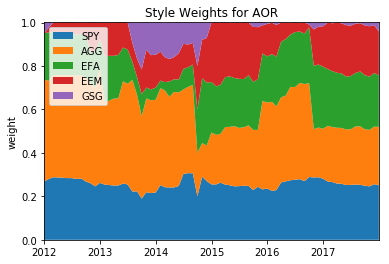

In [11]:
regression = np.zeros((len(returns.index)-11,5))
for row in range(11, len(returns.index)):
    ret = returns.iloc[row-11:row,:]
    aor_style = SharpeStyleAnalysis('AOR',ret)
    regression[row-11] = aor_style.Weight

style_roll_weights = pd.DataFrame(data=regression, index=returns.index[11:], columns=ret.columns[ret.columns != 'AOR'])

plt.stackplot(style_roll_weights.index, 
              style_roll_weights['SPY'], style_roll_weights['AGG'], style_roll_weights['EFA'],  style_roll_weights['EEM'],  style_roll_weights['GSG']
              , labels=['SPY','AGG','EFA','EEM','GSG'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Style Weights for AOR')
plt.ylabel("weight")

plt.show()

In [4]:
# 9.1.2
import statsmodels.api as sm
regression_1 = sm.OLS(returns.AOR,returns.iloc[:,0:-1]).fit()
regression_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AOR   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     321.9
Date:                Thu, 10 Jan 2019   Prob (F-statistic):           5.36e-51
Time:                        12:29:19   Log-Likelihood:                 443.17
No. Observations:                  84   AIC:                            -876.3
Df Residuals:                      79   BIC:                            -864.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SPY            0.4319      0.040     10.841      0.000       0.353       0.511
AGG            0.4071      0.080      5.074      0.000       0.247       0.567
EFA            0.1303      0.028      4.652      0.000       0.075       0.186
EEM            0.0268      0.020      1.362      0.177      -0.012       0.066
GSG           -0.0065      0.010     -0.629      0.531      -0.027       0.014
==============================================================================
Omnibus:                        0.215   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.248
Skew:                          -0.115   Prob(JB):                        0.884
Kurtosis:                       2.866   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 9.2.1
regression = np.zeros((len(returns.index)-11,5))

for row in range(11, len(returns.index)):
    y = returns.AOR[row-11: row]
    x = returns.iloc[row-11:row,:-1]
    aor_style = optimize.nnls(x,y)
    weights = np.round(aor_style[0]/sum(aor_style[0]), 4)
    regression[row-11] = weights

style_roll_weights = pd.DataFrame(data=regression, index=returns.index[11:], columns=tickers[:-1])
style_roll_weights.head()


In [ ]:
# 9.2.2
plt.stackplot(style_roll_weights.index, 
              style_roll_weights['SPY'], style_roll_weights['AGG'], style_roll_weights['EFA'],  style_roll_weights['EEM'],  style_roll_weights['GSG']
              , labels=['SPY','AGG','EFA','EEM','GSG'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Style Weights for AOR')
plt.ylabel("weight")

plt.show()

In [ ]:
# 9.3.1
from scipy import optimize

start_date='2006-12-31'
end_date='2015-12-31'
tickers = ["XLF", 
            "XLK", 
            "XLI", 
            "XLB", 
            "XLY", 
            "XLV", 
            "XLU", 
            "XLP", 
            "XLE", 
            "VOX", 
            "VNQ", 
            "SPY"]

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()
returns = returns.resample('1M', closed='left').first()

# generate style weights
regression = np.zeros((len(returns.index)-11,11))

for row in range(11, len(returns.index)):
    y = returns.SPY[row-11: row]
    x = returns.iloc[row-11:row,:-1]
    aor_style = optimize.nnls(x,y)
    weights = np.round(aor_style[0]/sum(aor_style[0]), 4)
    regression[row-11] = weights

style_roll_weights_sp = pd.DataFrame(data=regression, index=returns.index[11:], columns=tickers[:-1])
# transform weights to end of quarter frequency
weights_1 = style_roll_weights_sp.resample('BQ',closed='right').first()

# create replicated SPY index with
# quarterly rebalancing.
weights = weights_1
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
s1 = bt.Strategy('Replicated', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                        bt.algos.WeighTarget(weights),
                       bt.algos.Rebalance()])
s2 = bt.Strategy('Actual', [bt.algos.RunOnce(),
                                       bt.algos.SelectAll(),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])
prices = np.cumprod(np.exp(returns.iloc[11:,:]))
test1 = bt.Backtest(s1, prices.iloc[:,:-1],progress_bar=False)
test2 = bt.Backtest(s2, prices.iloc[:,-1:],progress_bar=False)
res = bt.run(test1,test2)
res.plot()

In [ ]:
# 9.3.2
np.corrcoef(res.prices.Actual,res.prices.Replicated)

# 10 - Estimating Shocks on Asset Prices

In [ ]:
##############
# Chapter 10 #
##############
 
# 10.1.1
import pandas_datareader as pdr
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

fred = pdr.get_data_fred(['MCOILWTICO','RU1000TR'],start = "1986-01-01")
fred.fillna(method='ffill')
oil_r1000 = fred.resample('1M', closed='left').first()
oil_r1000.columns = ['oil','stocks']
oil_r1000_ret =oil_r1000.pct_change().dropna()
model = VAR(oil_r1000_ret)
var_lag = model.select_order(maxlags=12).aic
var_model = VAR(oil_r1000_ret*100)
results = var_model.fit(maxlags=12, ic='aic')

In [ ]:
# 10.1.2
irf = results.irf(periods=12)
irf.plot(impulse='oil',response='stocks',orth=False)

In [ ]:
irf.plot()

In [ ]:
# 10.1.3
irf_data = plt.plot(irf.irfs[:,1,0])


In [ ]:

# 10.1.3
irf.data <-irf(var.model,
               impulse="oil", 
               response="stocks", 
               boot=T, 
               n.ahead=12,
               cumulative=F)
 
irf.data$irf   # point estimates
irf.data$Upper # upper confidence band
irf.data$Lower # lower confidence band
 
irf.data$irf
 
# 10.1.4
irf.num <-unlist(irf.data$irf, use.names=F)
 
# 10.1.5
irf.data$irf$oil
 
# 10.1.6
irf.data$irf$oil * 2   # two std dev shock
irf.data$irf$oil * -1  # negative shock for one std dev
 

# RECYLCE

In [ ]:
from qpsolvers import solve_qp
from cvxopt import matrix,solvers

In [ ]:
from cvxopt import matrix, solvers
Q = 2*matrix([ [2, .5], [.5, 1] ])
p = matrix([1.0, 1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
sol=solvers.qp(Q, p, G, h, A, b)

In [ ]:
print(sol['x'])

In [ ]:
def Cols(x):
    return x.shape[1]

def Rows(x):
    x.shape[0]
    

def Correl(x, y):
    c = np.corrcoef(x,y)
    return c[0,1]

def Covar(S, F):
    X = np.sqrt(abs(S))
    cov = np.dot(F.T - F.mean(), X - X.mean(axis=0)) / (F.shape[0]-1)
    return cov

def TEMINQP(F,S):
    s = Cols(S)
    V = np.cov(S)
    C = Covar(S,F)
    Aeq = np.ones(shape=(1,s))
    beq = 1
    lb = np.zeros(shape=(1,s))
return solve_qp(P=V, q=-C, A=Aeq, b=beq)
    
fund_returns = np.array(returns.AOR)
style_returns = np.matrix(returns.iloc[:,:-1])
TEMINQP(fund_returns, style_returns)